In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd

# Use LaTeX for rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Warning:
The first few cells are slow

Increase alpha step and kappa step to get a better resolution


In [5]:
from Theory_no_noise import theory

# Increase alpha step and kappa step to get a better resolution

alpha_min = 1e-3
alpha_max = 0.6
alpha_step = 32

kappa_min = 1e-3
kappa_max = 2
kappa_step = 32

# Make a grid
gen_error = np.zeros((alpha_step, kappa_step))

for i, alpha in tqdm(enumerate(np.linspace(alpha_min, alpha_max, alpha_step))):
    for j, kappa in enumerate(np.linspace(kappa_min, kappa_max, kappa_step)):
        if kappa <= 1.0:
            if alpha < kappa - kappa**2/2:
                gen_error[i,j] = theory(alpha, kappa) * kappa
            else:
                gen_error[i,j] = 0.0
        else:
            if alpha < 0.5:
                gen_error[i,j] = theory(alpha, kappa) * kappa
            else:
                gen_error[i,j] = 0.0
        # print(f"iter {i},{j}: alpha = {alpha}, kappa = {kappa}, gen_error = {gen_error[i,j]}")


np.save("phase_plot.npy", np.flip(gen_error,axis=1).T)

1it [00:02,  2.85s/it]


KeyboardInterrupt: 

In [7]:
# kappa_list = [0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 5.0]

kappa_list = [2.0]

for kappa in kappa_list:
    alpha_min = 1e-3
    if kappa < 1.0:
        alpha_max = kappa - kappa**2/2
    else:
        alpha_max = 0.5

    alpha_step = 128
    alpha_list = np.linspace(alpha_min, alpha_max, alpha_step)

    gen_error_planted = np.zeros(alpha_step)
    for i in tqdm(range(alpha_step)):
        gen_error_planted[i] = theory(alpha_list[i], kappa) * kappa

    pd.DataFrame({"alpha":alpha_list, "gen_error":gen_error_planted}).to_csv(f"data_theory/line_no_noise_{kappa}.csv")

100%|██████████| 128/128 [00:46<00:00,  2.78it/s]


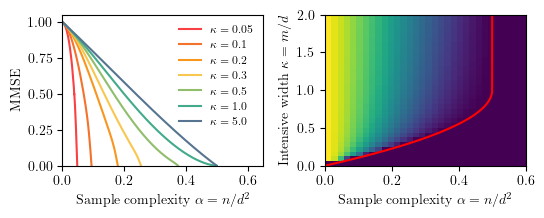

In [4]:
colors = ["#377eb8", "#e41a1c", "#4daf4a"]
fig, ax = plt.subplots(1,2, figsize=(2.4*2.2816, 2.2816))


plt.subplot(1, 2, 2)


alpha_min = 0
alpha_max = 0.6

kappa_min = 0
kappa_max = 2
plt.imshow(np.load("phase_plot.npy"), extent=[alpha_min, alpha_max,kappa_min, kappa_max], aspect='auto', cmap='viridis')
# plt.colorbar()
plt.ylabel(r'Intensive width $\kappa = m/d$')
plt.xlabel(r'Sample complexity $\alpha=n/d^2$')


kappa_step=128
kappa_y = np.linspace(kappa_max, kappa_min, kappa_step)
alpha_x = np.zeros(kappa_step)
for i, kappa in enumerate(kappa_y):
    if kappa_y[i] <= 1.0:
        alpha_x[i] = kappa - kappa**2/2
    else:
        alpha_x[i] = 0.5

plt.plot(alpha_x, kappa_y, 'r')





plt.subplot(1, 2, 1)



colors = ["#f94144", "#f3722c", "#f8961e", "#f9c74f", "#90be6d", "#43aa8b", "#577590"]

kappa_list = [0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 5.0]

for i, kappa in enumerate(kappa_list):
    df = pd.read_csv(f"data_theory/line_no_noise_{kappa}.csv")
    plt.plot(df["alpha"], df["gen_error"], label=fr'$\kappa = {kappa}$', color=colors[i])


plt.ylim(0, 1.05)
plt.xlim(0, 0.65)

plt.ylabel(r'MMSE')
plt.xlabel(r'Sample complexity $\alpha=n/d^2$')

plt.legend(fontsize=8, frameon=False)

plt.tight_layout()
plt.savefig("figures/theory.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [5]:
from Theory_noise import theory as theory_noise

kappa_list = [0.5]
delta = 0.25


sigma = np.sqrt(delta)

for kappa in kappa_list:
    alpha_min = 1e-3
    alpha_max = 0.5

    alpha_step = 128
    alpha_list = np.linspace(alpha_min, alpha_max, alpha_step)

    gen_error_planted = np.zeros(alpha_step)
    for i in tqdm(range(alpha_step)):
        gen_error_planted[i] = theory_noise(alpha_list[i], kappa, sigma) * kappa

    pd.DataFrame({"alpha":alpha_list, "gen_error":gen_error_planted}).to_csv(f"data_theory/line_noise_{kappa}_{delta}.csv")

100%|██████████| 128/128 [00:03<00:00, 36.75it/s]


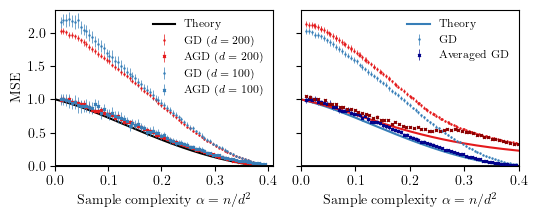

In [6]:
colors = ["#377eb8", "#e41a1c", "#4daf4a"]
fig, ax = plt.subplots(1,2, figsize=(2.4*2.2816, 2.2816), sharey=True)



plt.subplot(1, 2, 1)

skip = 0
beta = 0.5
betastar = 0.5
lr = 0.1

D = 200
samples_average = 64


data = pd.read_csv(f"data_theory/line_no_noise_{beta}.csv")
plt.plot(data["alpha"][skip:], data["gen_error"][skip:], label="Theory", color="black")
plt.axhline(0, color='black', linewidth=2)
plt.plot(0.5-0.5**2/2, 0, marker="o", markersize=3, color="black")


alpha_sim = []
for file in os.listdir("data_simulations_standard"):
    if file.startswith("gen_error"):
        _, _, D_file, alpha_file, beta_file, betastar_file, lr_file, _ = file.split("_")
        D_file = int(D_file)
        alpha_file = float(alpha_file)
        beta_file = float(beta_file)
        betastar_file = float(betastar_file)
        lr_file = float(lr_file)

        if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file:
            alpha_sim.append(alpha_file)


alpha_sim_average = []
for file in os.listdir("data_simulations_averaged"):
    if file.startswith("gen_error"):
        _, _, D_file, alpha_file, beta_file, betastar_file, samples_average_file, lr_file, _ = file.split("_")
        D_file = int(D_file)
        alpha_file = float(alpha_file)
        beta_file = float(beta_file)
        betastar_file = float(betastar_file)
        samples_average_file = int(samples_average_file)
        lr_file = float(lr_file)

        if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file and samples_average_file==samples_average:
            alpha_sim_average.append(alpha_file)


alpha_sim = np.sort(np.array(alpha_sim))
alpha_sim_average = np.sort(np.array(alpha_sim_average))

gen_error_sim_mean = np.zeros_like(alpha_sim)
gen_error_sim_std = np.zeros_like(alpha_sim)
for i,a in enumerate(alpha_sim):
    gen_error = np.load(f"data_simulations_standard/gen_error_{D}_{a}_{beta}_{betastar}_{lr}_gaussian.npy") /2
    gen_error_sim_mean[i] = gen_error[:, -1].mean()
    gen_error_sim_std[i] = gen_error[:, -1].std()#/np.sqrt(gen_error.shape[0])

gen_error_sim_average_mean = np.zeros_like(alpha_sim_average)
gen_error_sim_average_std = np.zeros_like(alpha_sim_average)
for i,a in enumerate(alpha_sim_average):
    gen_error = np.load(f"data_simulations_averaged/gen_error_{D}_{a}_{beta}_{betastar}_{samples_average}_{lr}_gaussian.npy")/2
    gen_error_sim_average_mean[i] = gen_error.mean()
    gen_error_sim_average_std[i] = gen_error.std()#/np.sqrt(gen_error.shape[0])
    


plt.errorbar(alpha_sim, gen_error_sim_mean, gen_error_sim_std, marker='.', linestyle='None', markersize=1.5, lw=0.5, color=colors[1], label=rf'GD ($d={D}$)')
plt.errorbar(alpha_sim_average, gen_error_sim_average_mean, gen_error_sim_std, marker='x', linestyle='None', lw=0.5, markersize=2, color=colors[1], label=fr"AGD ($d={D}$)")








D = 100
alpha_sim = []
for file in os.listdir("data_simulations_standard"):
    if file.startswith("gen_error"):
        _, _, D_file, alpha_file, beta_file, betastar_file, lr_file, _ = file.split("_")
        D_file = int(D_file)
        alpha_file = float(alpha_file)
        beta_file = float(beta_file)
        betastar_file = float(betastar_file)
        lr_file = float(lr_file)

        if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file:
            alpha_sim.append(alpha_file)


alpha_sim_average = []
for file in os.listdir("data_simulations_averaged"):
    if file.startswith("gen_error"):
        _, _, D_file, alpha_file, beta_file, betastar_file, samples_average_file, lr_file, _ = file.split("_")
        D_file = int(D_file)
        alpha_file = float(alpha_file)
        beta_file = float(beta_file)
        betastar_file = float(betastar_file)
        samples_average_file = int(samples_average_file)
        lr_file = float(lr_file)

        if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file and samples_average_file==samples_average:
            alpha_sim_average.append(alpha_file)


alpha_sim = np.sort(np.array(alpha_sim))
alpha_sim_average = np.sort(np.array(alpha_sim_average))

gen_error_sim_mean = np.zeros_like(alpha_sim)
gen_error_sim_std = np.zeros_like(alpha_sim)
for i,a in enumerate(alpha_sim):
    gen_error = np.load(f"data_simulations_standard/gen_error_{D}_{a}_{beta}_{betastar}_{lr}_gaussian.npy")/2 
    gen_error_sim_mean[i] = gen_error[:, -1].mean()
    gen_error_sim_std[i] = gen_error[:, -1].std()#/np.sqrt(gen_error.shape[0])

gen_error_sim_average_mean = np.zeros_like(alpha_sim_average)
gen_error_sim_average_std = np.zeros_like(alpha_sim_average)
for i,a in enumerate(alpha_sim_average):
    gen_error = np.load(f"data_simulations_averaged/gen_error_{D}_{a}_{beta}_{betastar}_{samples_average}_{lr}_gaussian.npy")/2
    gen_error_sim_average_mean[i] = gen_error.mean()
    gen_error_sim_average_std[i] = gen_error.std()#/np.sqrt(gen_error.shape[0])
    


plt.errorbar(alpha_sim, gen_error_sim_mean, gen_error_sim_std, marker='.', linestyle='None', markersize=1.5, lw=0.5, color=colors[0], label=rf'GD ($d={D}$)')
plt.errorbar(alpha_sim_average, gen_error_sim_average_mean, gen_error_sim_std, marker='x', linestyle='None', lw=0.5, markersize=2, color=colors[0], label=fr"AGD ($d={D}$)")


plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel(r'Sample complexity $\alpha=n/d^2$')
plt.ylabel(r'MSE')

plt.legend(fontsize=8, frameon=False)
plt.ylim((0, 5.7/2))
plt.xlim((0, 0.41))

plt.axhline(0, color='black', linewidth=2, zorder=10)



plt.subplot(1, 2, 2)



skip = 0
beta = 0.5
betastar = 0.5
lr = 0.1

D = 200
samples_average = 64




alpha_sim = []
for file in os.listdir("data_simulations_standard"):
    if file.startswith("gen_error"):
        _, _, D_file, alpha_file, beta_file, betastar_file, lr_file, _ = file.split("_")
        D_file = int(D_file)
        alpha_file = float(alpha_file)
        beta_file = float(beta_file)
        betastar_file = float(betastar_file)
        lr_file = float(lr_file)

        if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file:
            alpha_sim.append(alpha_file)


alpha_sim_average = []
for file in os.listdir("data_simulations_averaged"):
    if file.startswith("gen_error"):
        _, _, D_file, alpha_file, beta_file, betastar_file, samples_average_file, lr_file, _ = file.split("_")
        D_file = int(D_file)
        alpha_file = float(alpha_file)
        beta_file = float(beta_file)
        betastar_file = float(betastar_file)
        samples_average_file = int(samples_average_file)
        lr_file = float(lr_file)

        if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file and samples_average_file==samples_average:
            alpha_sim_average.append(alpha_file)


alpha_sim = np.sort(np.array(alpha_sim))
alpha_sim_average = np.sort(np.array(alpha_sim_average))

gen_error_sim_mean = np.zeros_like(alpha_sim)
gen_error_sim_std = np.zeros_like(alpha_sim)
for i,a in enumerate(alpha_sim):
    gen_error = np.load(f"data_simulations_standard/gen_error_{D}_{a}_{beta}_{betastar}_{lr}_gaussian.npy") /2
    gen_error_sim_mean[i] = gen_error[:, -1].mean()
    gen_error_sim_std[i] = gen_error[:, -1].std()#/np.sqrt(gen_error.shape[0])

gen_error_sim_average_mean = np.zeros_like(alpha_sim_average)
gen_error_sim_average_std = np.zeros_like(alpha_sim_average)
for i,a in enumerate(alpha_sim_average):
    gen_error = np.load(f"data_simulations_averaged/gen_error_{D}_{a}_{beta}_{betastar}_{samples_average}_{lr}_gaussian.npy")/2
    gen_error_sim_average_mean[i] = gen_error.mean()
    gen_error_sim_average_std[i] = gen_error.std()#/np.sqrt(gen_error.shape[0])
    


plt.errorbar(alpha_sim, gen_error_sim_mean, gen_error_sim_std, marker='.', label=f'GD', linestyle='None', markersize=1.5, lw=0.5, color=colors[0])
plt.errorbar(alpha_sim_average, gen_error_sim_average_mean, gen_error_sim_std, marker='x', label=f'Averaged GD', linestyle='None', lw=0.5, markersize=2, color="darkblue")

data = pd.read_csv(f"data_theory/line_no_noise_{beta}.csv")
plt.plot(data["alpha"][skip:], data["gen_error"][skip:], label="Theory", color=colors[0])

sigma_list = np.array([0.25])

for j,sigma in enumerate(sigma_list):
    alpha_sim = []
    for file in os.listdir("data_simulations_standard_noise_teacher"):
        if file.startswith("gen_error"):
            _, _, D_file, alpha_file, beta_file, betastar_file, sigma_file, lr_file, _ = file.split("_")
            D_file = int(D_file)
            alpha_file = float(alpha_file)
            beta_file = float(beta_file)
            betastar_file = float(betastar_file)
            lr_file = float(lr_file)
            sigma_file = float(sigma_file)

            if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file and sigma==sigma_file:
                alpha_sim.append(alpha_file)


    alpha_sim = np.sort(np.array(alpha_sim))

    gen_error_sim_mean = np.zeros_like(alpha_sim)
    gen_error_sim_std = np.zeros_like(alpha_sim)
    for i,a in enumerate(alpha_sim):
        gen_error = np.load(f"data_simulations_standard_noise_teacher/gen_error_{D}_{a}_{beta}_{betastar}_{sigma}_{lr}_gaussian.npy") /2
        gen_error_sim_mean[i] = gen_error[:, -1].mean()
        gen_error_sim_std[i] = gen_error[:, -1].std()#/np.sqrt(gen_error.shape[0])



    plt.errorbar(alpha_sim, gen_error_sim_mean, gen_error_sim_std, marker='.', linestyle='None', markersize=1.5, lw=0.5, color=colors[1])



    data = pd.read_csv(f"data_theory/line_noise_{beta}_{sigma}.csv")
    plt.plot(data["alpha"][skip:], data["gen_error"][skip:], color=colors[1])


plt.axhline(0, color='black', linewidth=2)


alpha_sim_average = []
for file in os.listdir("data_simulations_averaged_noise_teacher"):
    if file.startswith("gen_error"):
        _, _, D_file, alpha_file, beta_file, betastar_file, sigma_file, reg_file, samples_average_file, lr_file, _ = file.split("_")
        D_file = int(D_file)
        alpha_file = float(alpha_file)
        beta_file = float(beta_file)
        betastar_file = float(betastar_file)
        samples_average_file = int(samples_average_file)
        lr_file = float(lr_file)
        sigma_file = float(sigma_file)
        reg_file = float(reg_file)

        if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file and sigma==sigma_file and 0.0==reg_file:
            alpha_sim_average.append(alpha_file)


alpha_sim = np.sort(np.array(alpha_sim))
alpha_sim_average = np.sort(np.array(alpha_sim_average))


gen_error_sim_average_mean = np.zeros_like(alpha_sim_average)
gen_error_sim_average_std = np.zeros_like(alpha_sim_average)
for i,a in enumerate(alpha_sim_average):
    gen_error = np.load(f"data_simulations_averaged_noise_teacher/gen_error_{D}_{a}_{beta}_{betastar}_{sigma}_{0.0}_{samples_average_file}_{lr}_gaussian.npy")/2
    gen_error_sim_average_mean[i] = gen_error.mean()
    gen_error_sim_average_std[i] = gen_error.std()#/np.sqrt(gen_error.shape[0])

plt.errorbar(alpha_sim_average, gen_error_sim_average_mean, gen_error_sim_average_std, marker='x', linestyle='None', lw=0.5, markersize=2, color="darkred")



plt.legend(fontsize=8, frameon=False)

plt.xlabel(r"Sample complexity $\alpha=n/d^2$")
# plt.ylabel("MSE")

plt.xlim((0,.4))
plt.ylim((0,4.7/2))

plt.tight_layout()
plt.savefig("figures/GD.pdf", bbox_inches='tight', dpi=300)
plt.show()

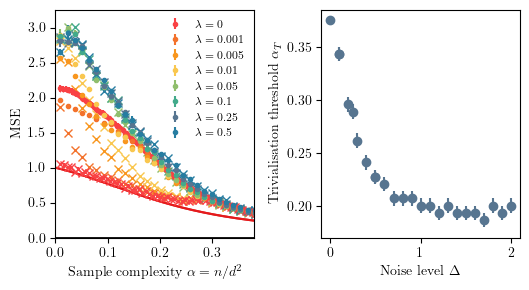

In [7]:
skip = 0
beta = 0.5
betastar = 0.5
lr = 0.1

D = 200
samples_average = 64



plt.figure(figsize=(5.4, 3.0))
plt.subplot(1,2,1)



color_list = ["#f94144", "#f3722c", "#f8961e", "#f9c74f", "#90be6d", "#43aa8b", "#577590", "#277da1", "#2a9d8f", "#17c3b2"]


for j,sigma in enumerate(sigma_list):
    alpha_sim = []
    for file in os.listdir("data_simulations_standard_noise_teacher"):
        if file.startswith("gen_error"):
            _, _, D_file, alpha_file, beta_file, betastar_file, sigma_file, lr_file, _ = file.split("_")
            D_file = int(D_file)
            alpha_file = float(alpha_file)
            beta_file = float(beta_file)
            betastar_file = float(betastar_file)
            lr_file = float(lr_file)
            sigma_file = float(sigma_file)

            if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file and sigma==sigma_file:
                alpha_sim.append(alpha_file)


    alpha_sim = np.sort(np.array(alpha_sim))

    gen_error_sim_mean = np.zeros_like(alpha_sim)
    gen_error_sim_std = np.zeros_like(alpha_sim)
    for i,a in enumerate(alpha_sim):
        gen_error = np.load(f"data_simulations_standard_noise_teacher/gen_error_{D}_{a}_{beta}_{betastar}_{sigma}_{lr}_gaussian.npy") /2
        gen_error_sim_mean[i] = gen_error[:, -1].mean()
        gen_error_sim_std[i] = gen_error[:, -1].std()#/np.sqrt(gen_error.shape[0])



    plt.errorbar(alpha_sim, gen_error_sim_mean, gen_error_sim_std, marker='.', linestyle='None', markersize=1.5, lw=0.5, color=colors[1])



    data = pd.read_csv(f"data_theory/line_noise_{beta}_{sigma}.csv")
    plt.plot(data["alpha"][skip:], data["gen_error"][skip:], color=colors[1])


plt.axhline(0, color='black', linewidth=2)


alpha_sim_average = []
for file in os.listdir("data_simulations_averaged_noise_teacher"):
    if file.startswith("gen_error"):
        _, _, D_file, alpha_file, beta_file, betastar_file, sigma_file, reg_file, samples_average_file, lr_file, _ = file.split("_")
        D_file = int(D_file)
        alpha_file = float(alpha_file)
        beta_file = float(beta_file)
        betastar_file = float(betastar_file)
        samples_average_file = int(samples_average_file)
        lr_file = float(lr_file)
        sigma_file = float(sigma_file)
        reg_file = float(reg_file)

        if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file and sigma==sigma_file and 0.0==reg_file:
            alpha_sim_average.append(alpha_file)


alpha_sim = np.sort(np.array(alpha_sim))
alpha_sim_average = np.sort(np.array(alpha_sim_average))


gen_error_sim_average_mean = np.zeros_like(alpha_sim_average)
gen_error_sim_average_std = np.zeros_like(alpha_sim_average)
for i,a in enumerate(alpha_sim_average):
    gen_error = np.load(f"data_simulations_averaged_noise_teacher/gen_error_{D}_{a}_{beta}_{betastar}_{sigma}_{0.0}_{samples_average_file}_{lr}_gaussian.npy")/2
    gen_error_sim_average_mean[i] = gen_error.mean()
    gen_error_sim_average_std[i] = gen_error.std()#/np.sqrt(gen_error.shape[0])

plt.errorbar(alpha_sim, gen_error_sim_mean, gen_error_sim_std, marker='.', label=fr'$\lambda = {0}$', linestyle='None', color=color_list[0])
plt.errorbar(alpha_sim_average, gen_error_sim_average_mean, gen_error_sim_average_std, marker='x', linestyle='None', color=color_list[0])



for j,reg in enumerate([0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5]):
    alpha_sim = []
    for file in os.listdir("data_simulations_standard_noise_teacher_reg"):
        if file.startswith("gen_error"):
            _, _, D_file, alpha_file, beta_file, betastar_file, sigma_file, reg_file, lr_file, _ = file.split("_")
            D_file = int(D_file)
            alpha_file = float(alpha_file)
            beta_file = float(beta_file)
            betastar_file = float(betastar_file)
            lr_file = float(lr_file)
            sigma_file = float(sigma_file)
            reg_file = float(reg_file)

            if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file and sigma==sigma_file and reg==reg_file:
                alpha_sim.append(alpha_file)

    alpha_sim_average = []
    for file in os.listdir("data_simulations_averaged_noise_teacher_reg"):
        if file.startswith("gen_error"):
            _, _, D_file, alpha_file, beta_file, betastar_file, sigma_file, reg_file, samples_average_file, lr_file, _ = file.split("_")
            D_file = int(D_file)
            alpha_file = float(alpha_file)
            beta_file = float(beta_file)
            betastar_file = float(betastar_file)
            samples_average_file = int(samples_average_file)
            lr_file = float(lr_file)
            sigma_file = float(sigma_file)
            reg_file = float(reg_file)

            if D==D_file and beta==beta_file and betastar==betastar_file and lr==lr_file and sigma==sigma_file and reg==reg_file:
                alpha_sim_average.append(alpha_file)


    alpha_sim = np.sort(np.array(alpha_sim))
    alpha_sim_average = np.sort(np.array(alpha_sim_average))

    gen_error_sim_mean = np.zeros_like(alpha_sim)
    gen_error_sim_std = np.zeros_like(alpha_sim)
    for i,a in enumerate(alpha_sim):
        gen_error = np.load(f"data_simulations_standard_noise_teacher_reg/gen_error_{D}_{a}_{beta}_{betastar}_{sigma}_{reg}_{lr}_gaussian.npy")/2
        gen_error_sim_mean[i] = gen_error[:, -1].mean()
        gen_error_sim_std[i] = gen_error[:, -1].std()/np.sqrt(gen_error.shape[0])

    gen_error_sim_average = np.zeros_like(alpha_sim_average)
    for i,a in enumerate(alpha_sim_average):
        gen_error_sim_average[i] = np.load(f"data_simulations_averaged_noise_teacher_reg/gen_error_{D}_{a}_{beta}_{betastar}_{sigma}_{reg}_{samples_average_file}_{lr}_gaussian.npy")/2


    plt.errorbar(alpha_sim, gen_error_sim_mean, gen_error_sim_std, marker='.', label=fr'$\lambda = {reg}$', linestyle='None', color=color_list[j+1])
    plt.plot(alpha_sim_average, gen_error_sim_average, marker='x', linestyle='None', color=color_list[j+1])


data = pd.read_csv(f"data_theory/line_noise_{beta}_{sigma}.csv")
plt.plot(data["alpha"][skip:], data["gen_error"][skip:], color=colors[1])


plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel(r'Sample complexity $\alpha = n/d^2$')
plt.ylabel(r'MSE')
plt.legend(fontsize=8, frameon=False)
plt.ylim((0,6.5/2))
plt.xlim((0,0.38))

plt.subplot(1,2,2)

df = pd.read_csv("critical_noise_0.5.csv")
delta = df["sigma"]
threshold = df["alpha"]


err = np.ones(len(df["sigma"])) * 0.0068056
err[0] = 0

plt.errorbar(delta, threshold, err, marker='o', linestyle='None', color=color_list[6])
plt.xlabel(r"Noise level $\Delta$")
plt.ylabel(r"Trivialisation threshold $\alpha_T$")

plt.tight_layout()
plt.savefig("figures/regularisation.pdf", bbox_inches='tight', dpi=300)
plt.show()